# Setup (Only run if RocketCEA hasn't been built)

In [3]:
!pip install RocketCEA

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.5/38.5 MB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for RocketCEA: filename=rocketcea-1.1.34-cp310-cp310-linux_x86_64.whl size=5294377 sha256=6afa1143f804d623de2ff15504e1a8e967f22de7eef8504b85d68193fb7363b5
  Stored in directory: /root/.cache/pip/wheels/0a/c6/78/09f751e0e6185bac68940ca41d7ce5038ccd506209a8339781
Successfully built RocketCEA


In [4]:
!pip install pint

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 kB 3.8 MB/s eta 0:00:00


To verify that this works, the following code will be ran.

In [5]:
from rocketcea.cea_obj import CEA_Obj, add_new_fuel
C = CEA_Obj( oxName='LOX', fuelName='LH2')
for mr in range(2,9):
    print(mr, C.get_Isp(Pc=100.0, MR=mr, eps=40.0) )

2 424.3597085736007
3 445.44434236555196
4 453.1327195192172
5 453.240429182712
6 448.1902329983734
7 438.7434004290928
8 424.6998266323161


In [6]:
!pip install pyfluids

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 31.7 MB/s eta 0:00:00


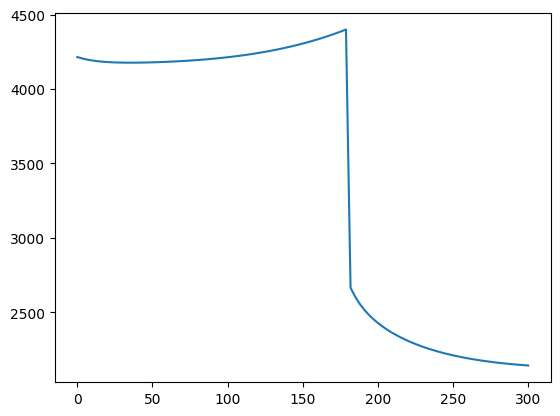

In [7]:
from pyfluids import Fluid, FluidsList, Input
import numpy as np
from matplotlib import pyplot as plt

templist = np.linspace(0, 300, 100)
dens = np.zeros(100)
for i, temp in enumerate(templist):
  methanol = Fluid(FluidsList.Water).with_state(Input.pressure(10e5), Input.temperature(temp))
  dens[i] = methanol.specific_heat
plt.plot(templist, dens)
plt.show()

In [8]:
test_fluid = Fluid(FluidsList.Methanol).with_state(Input.pressure(40e5), Input.temperature(298.15 - 273.15))
print(f'Temperature:,{test_fluid.temperature}')
print(f'Pressure: {test_fluid.pressure}')
print()
print(f'Specific Heat: {test_fluid.specific_heat}')
print(f'Density: {test_fluid.density}')
print(f'Viscosity: {test_fluid.dynamic_viscosity}')
print(f'Conductivity: {test_fluid.conductivity}')

Temperature:,25.0
Pressure: 4000000.0

Specific Heat: 2526.3100048296174
Density: 790.3869027748791
Viscosity: 0.0005577267102988393
Conductivity: 0.20218200130080832


# Classes to generate rocket engine and contour

Firstly, a CEA wrapper

In [9]:
from rocketcea.cea_obj_w_units import CEA_Obj
import numpy as np
import rocketcea.cea_obj
class RocketEngine:
  def __init__(self, oxName, fuelName, thrust, Pc, Pe, MR):
    self.oxName = oxName
    self.fuelName = fuelName
    self.Pc = Pc
    self.Pe = Pe
    self.MR = MR

    self.cea = CEA_Obj(oxName = oxName,
                       fuelName = fuelName,
                       isp_units='sec',
                       cstar_units = 'm/s',
                       pressure_units='Bar',
                       temperature_units='K',
                       sonic_velocity_units='m/s',
                       enthalpy_units='J/g',
                       density_units='kg/m^3',
                       specific_heat_units='J/kg-K',
                       viscosity_units='lbf-sec/sqin',      # wtf
                       thermal_cond_units='mcal/cm-K-s',  # wtf
                       fac_CR=None,
                       make_debug_prints=False)

    self.eps = self.cea.get_eps_at_PcOvPe(Pc=Pc, MR=MR, PcOvPe = Pc/Pe)
    self.Tc, self.Tt, self.Te = self.cea.get_Temperatures(Pc=Pc, MR=MR, eps=self.eps)
    self.Pt = self.Pc / self.cea.get_Throat_PcOvPe(Pc=Pc, MR=MR)
    self.ve = self.cea.get_SonicVelocities(Pc=Pc,MR=MR,eps=self.eps)[2] * self.cea.get_MachNumber(Pc=Pc, MR=MR, eps=self.eps)
    self.mdot = thrust / self.ve

    self.mwt, self.gt = self.cea.get_Throat_MolWt_gamma(Pc=Pc, MR=MR, eps=self.eps)
    self.mwe, self.ge = self.cea.get_exit_MolWt_gamma(Pc=Pc, MR=MR, eps=self.eps)
    self.Rt = 8314.46 / self.mwt
    self.Re = 8314.46 / self.mwe

    self.Cp_c, self.Cp_t, self.Cp_e = self.cea.get_HeatCapacities(Pc=Pc, MR=MR, eps=self.eps)
    self.rho_c = self.cea.get_Chamber_Density(Pc=Pc, MR=MR, eps=self.eps)

    _, self.visc, self.k, self.pr = self.cea.get_Chamber_Transport(Pc=Pc, MR=MR, eps=self.eps)
    self.cstar = self.cea.get_Cstar(Pc=Pc, MR=MR)
    self.isp = self.cea.estimate_Ambient_Isp(Pc=Pc, MR=MR, eps=self.eps, Pamb=1)

    self.At = self.mdot / (self.Pt * 1e5) * np.sqrt(self.Rt * self.Tt / self.gt)
    self.Ae = self.At * self.eps

  def debug_print(self):
      debugObj = rocketcea.cea_obj.CEA_Obj(oxName=self.oxName, fuelName=self.fuelName)
      print(debugObj.get_full_cea_output(Pc=self.Pc, MR=self.MR, eps=self.eps, short_output=1, pc_units="bar"))

Then geometry is created following RPA convention as shown:

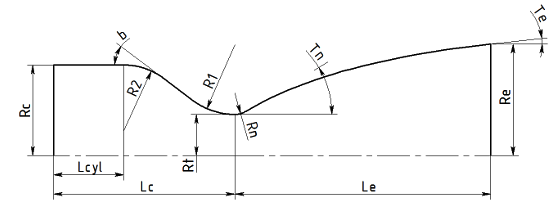

In [10]:
def lininterp(x, old_min, old_max, new_min, new_max):
  return (x - old_min)/(old_max - old_min) * (new_max - new_min) + new_min

def pointinterp(x, start, end):
  return np.array([start[0] + x * (end[0] - start[0]), start[1] + x * (end[1] - start[1])])

class Contour:
  def __init__(self, engine, chamber_length, radius_cylinder, points):
    rt = np.sqrt(engine.At / np.pi)
    re = np.sqrt(engine.Ae / np.pi)
    Le = 0.8 * rt * (np.sqrt(engine.eps) - 1) / np.tan(15 * np.pi / 180)
    total_length = chamber_length + Le

    Tn = 28 * np.pi / 180
    Te = 10 * np.pi / 180

    # Cyl (For my laziness assume R2 = 0)
    b = 45 * np.pi / 180
    x_conv = chamber_length + 1.5 * rt * np.cos(-b - np.pi / 2)
    y_conv = 2.5 * rt + 1.5 * rt * np.sin(-b - np.pi / 2)

    x_slope = (radius_cylinder - y_conv) / np.tan(b)

    contour_cyl = np.array([
        [0, radius_cylinder],
        [x_conv - x_slope,radius_cylinder],
        [x_conv,y_conv]])

    # Converge -> Throat

    contour_converge_throat = np.zeros((points - 1,2))
    for i in range(1, points):
      t = lininterp(i, 0, points - 1, -b - np.pi / 2, - np.pi / 2)
      contour_converge_throat[i - 1] = np.array([chamber_length + 1.5 * rt * np.cos(t), 2.5 * rt + 1.5 * rt * np.sin(t)])

    # Throat -> Parabola

    contour_throat_parabola = np.zeros((points - 1,2))
    for i in range(1, points):
      t = lininterp(i, 0, points - 1, 0 - np.pi / 2, Tn - np.pi / 2)
      contour_throat_parabola[i - 1] = np.array([chamber_length + 0.382 * rt * np.cos(t), 1.382 * rt + 0.382 * rt * np.sin(t)])

    # Parabola
    parabola_p0 = contour_throat_parabola[-1]
    parabola_p2 = np.array([total_length, re])
    parabola_m1 = np.tan(Tn)
    parabola_m2 = np.tan(Te)
    parabola_c1 = parabola_p0[1] - parabola_m1 * parabola_p0[0]
    parabola_c2 = parabola_p2[1] - parabola_m2 * parabola_p2[0]
    parabola_p1 = np.array([(parabola_c2 - parabola_c1)/(parabola_m1 - parabola_m2),(parabola_m1 * parabola_c2 - parabola_m2 * parabola_c1)/(parabola_m1 - parabola_m2)])

    contour_parabola = np.zeros((points - 1,2))
    for i in range(1, points):
      t = lininterp(i, 0, points - 1, 0, 1)
      parabola_linear0 = pointinterp(t, parabola_p0, parabola_p1)
      parabola_linear1 = pointinterp(t, parabola_p1, parabola_p2)
      contour_parabola[i - 1] = pointinterp(t, parabola_linear0, parabola_linear1)

    contour = np.concatenate([contour_cyl, contour_converge_throat, contour_throat_parabola, contour_parabola])
    self.x = np.linspace(contour[:,0].min(), contour[:,0].max(), num=points)
    self.r = np.interp(self.x, contour[:,0], contour[:,1])

    self.throat = (chamber_length, rt)
    self.exit = (total_length, re)
    self.rc = radius_cylinder
    self.parabola_p1 = parabola_p1
    self.points = points

In [11]:
from scipy.optimize import root_scalar
from pint import UnitRegistry, Quantity
ureg = UnitRegistry()
Q_ = ureg.Quantity


class Thermals:
  def __init__(self, engine, contour, transport_case):
    self.engine = engine
    self.contour = contour

    x_choke = np.argmin(contour.r)

    #Finding mach number, https://kyleniemeyer.github.io/gas-dynamics-notes/compressible-flows/isentropic.html#equation-eq-area-ratio-loss
    def area_function(mach, area, gamma):

      area_ratio = area / engine.At
      if mach == 0:
        mach = 0.000001
      return (
          area_ratio - (
              (1.0/mach) * ((1 + 0.5*(gamma-1)*mach*mach) /
              ((gamma + 1)/2))**((gamma+1) / (2*(gamma-1)))
              )
          )

    points = contour.points
    self.M = np.zeros(points)
    self.T = np.zeros(points)
    self.hg1 = np.zeros(points)
    self.hg2 = np.zeros(points)
    self.stag_recovery = np.zeros(points)

    Cv = engine.Cp_c - engine.Rt
    rt = np.sqrt(engine.At / np.pi)

    for i in range(0,contour.points):


      #Transport case:
      # 0 - throat transports until throat, then linearly interpolate to exit at exit
      # 1 - throat transports
      # 2 - exit transports
      if transport_case == 0:
        if i < x_choke:
          gamma = engine.gt
        else:
          gamma = lininterp(i, x_choke, contour.points, engine.gt, engine.ge)
      elif transport_case == 1:
        gamma = engine.gt
      elif transport_case == 2:
        gamma = engine.ge

      area = np.pi * contour.r[i] * contour.r[i]
      if i == x_choke:
        M = 1
      elif i < x_choke:
        M = root_scalar(area_function, args=(area, gamma), bracket=[0, 1]).root
      else:
        M = root_scalar(area_function, args=(area, gamma), bracket=[1, 10]).root
      self.M[i] = M

      T = engine.Tc - engine.mdot * engine.mdot / (2 * Cv * engine.rho_c * engine.rho_c * area * area) * (1 + 0.5 * (engine.gt - 1) * M * M)**(2 / (engine.gt - 1))
      self.T[i] = T
      correction_factor = 1 / ((0.5 * T / engine.Tc * (1 + 0.5 * (gamma - 1) * M**2)+0.5)**0.68 * (1 + 0.5 * (gamma - 1) * M**2)**0.12)


      r = contour.r[i]
      Cp = engine.Cp_c
      visc = engine.visc
      pr = engine.pr

      self.stag_recovery[i] = (1 + 0.5*(gamma - 1)*M**2*pr**0.33)

      #Bartz

      bPc = Q_(engine.Pc, ureg.bar).to('psi')
      bcstar = Q_(engine.cstar, ureg.meter / ureg.second).to('feet / second')
      bDt = Q_(np.sqrt(4 * engine.At / np.pi), ureg.meter).to('inch')
      bcurv = Q_((1.5 * rt + 0.382 * rt) * 0.5, ureg.meter).to("inch")
      bCp = Q_(Cp, ureg.joule / (ureg.kilogram * ureg.degK)).to('Btu / (lb * delta_degF)')
      bvisc = Q_(visc, ureg.lbf * ureg.second/ (ureg.inch ** 2))
      bg = Q_(9.81, ureg.meter / ureg.second**2).to('feet / second**2')
      bAtA = engine.At / area
      self.hg1[i] = Q_((0.026 / bDt**0.2 * (bvisc**0.2 * bCp / pr**0.6) * (bPc * bg / bcstar)**0.8 * (bDt / bcurv)**0.1 * bAtA**0.9 * correction_factor).magnitude, "Btu / (inch ** 2 * second)").to("W / (m**2)").magnitude

      #Adami
      R = engine.Rt
      Z = np.pi * contour.r[0]**2 / (2 * np.pi * contour.r[0] * contour.x[-1])
      self.hg2[i] = Z * engine.mdot / (2 * area) * Cp * visc**0.3 * pr **(2/3)


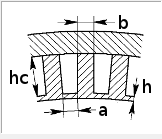

In [12]:
from pyfluids import Fluid, FluidsList, Input
import numpy as np
from matplotlib import pyplot as plt



class Channels:
  def __init__(self, engine, contour, thermals, h): #h = wall thickness

    T_max_wall = 523 #See source
    Tco = 400 #should be nucleate boiling liquid at 10 bars
    k = 10 #thermal conductiivty of AlSi10Mg

    methanol = Fluid(FluidsList.Methanol).with_state(Input.pressure(10e5), Input.temperature(temp))
    k = methanol.conductivity
    density = methanol.density
    pr = methanol.prandtl

    points = contour.points
    self.hc = np.zeros(points)
    self.a = np.zeros(points)
    self.A = np.zeros(points)
    self.per = np.zeros(points)

    r_list = contour.r

    hc0 = 0.001
    a0 = 0.004
    r0 = r_list[0]
    self.N = 40
    self.h = h

    for i, r in enumerate(r_list):
      hc = hc0
      a = a0 * (r + h) / (r0 + h)
      Area = hc0 * a

      a2 = a0 * (r + h + hc) / (r0 + h)

      self.hc[i] = hc0
      self.a[i] = a
      self.A[i] = hc0 * a
      self.per[i] = 2 * hc0 + a + a2

In [19]:
class ChannelSim:
  def __init__(self, engine, contour, thermals, channel):
    mdot = engine.mdot / (channel.N * (engine.MR + 1))
    #mdot = 0.5 / channel.N

    T_max_wall = 523 #See source
    k_metal = 100 #thermal conductiivty of AlSi10Mg

    points = contour.points
    self.Taw = np.zeros(points)
    self.Twg = np.zeros(points)
    self.Twc = np.zeros(points)
    self.Tco = np.zeros(points)
    self.velocity = np.zeros(points)
    self.hg = np.zeros(points)
    self.hc = np.zeros(points)
    self.hw = np.zeros(points)
    self.q = np.zeros(points)
    self.stress_pressure = np.zeros(points)
    self.stress_temperature = np.zeros(points)
    self.stress_temperature2 = np.zeros(points)
    self.stress_total = np.zeros(points)
    Tco_i = 300

    for i in range(contour.points-1, -1, -1):
      r = contour.r[i]
      T_inf = thermals.T[i]
      stag_recovery = thermals.stag_recovery[i]
      Taw = T_inf * 0.923
      hg = thermals.hg1[i]

      a = channel.a[i]
      A = channel.A[i]
      per = channel.per[i]

      methanol = Fluid(FluidsList.Methanol).with_state(Input.pressure(40e5), Input.temperature(Tco_i-275.15))

      k = methanol.conductivity
      density = methanol.density
      pr = methanol.prandtl
      viscosity = methanol.dynamic_viscosity
      cp = methanol.specific_heat

      Dh = 4 * A / per
      #velocity = mdot/(A * density * np.cos(30 * np.pi / 180))
      #velocity = mdot/(A * density * np.sin(np.arctan(204 / (75 * np.pi) * 0.075 / r)))
      velocity = mdot/(A * density)

      Twc = Tco_i + 100
      for j in range(0, 10):
        hc = 0.023 * k / Dh * (density * velocity * Dh / viscosity)**0.8 * pr ** 0.4 * (Twc / Tco_i)**-0.3
        H = 1 / (1 / hg + channel.h / k_metal + 1 / hc)
        #H = 1 / (1 / hg + 0.0001/1 + channel.h / k_metal + 1 / hc)
        q = H * (Taw - Tco_i)
        Twc = Tco_i + q / hc

      Twg = Twc + q * channel.h / k_metal

      stress_pressure = 0.5 * (40e5 - 1e5) * (a / channel.h) **2;
      stress_temperature = lininterp(Twg, 273, 773, 70e9, 50e9) * 24e-6 * q * channel.h * 0.5 / ((1 - 0.3) * k_metal)
      stress_temperature2 = lininterp(Twg, 273, 773, 70e9, 50e9) * 24e-6 * (Twg - Twc)


      self.Taw[i] = Taw
      self.Twg[i] = Twg
      self.Twc[i] = Twc
      self.Tco[i] = Tco_i
      self.velocity[i] = velocity
      self.hg[i] = hg
      self.hc[i] = hc
      self.hw[i] = k_metal / channel.h
      self.q[i] = q
      self.stress_pressure[i] = stress_pressure
      self.stress_temperature[i] = stress_temperature
      self.stress_temperature2[i] = stress_temperature2
      self.stress_total[i] = stress_pressure + stress_temperature + stress_temperature2

      dx = contour.x[1] - contour.x[0]
      Tco_i = Tco_i + 1 / (mdot * cp) * q * (2 * np.pi * r * dx / channel.N)

# Usage

Mass flux (kg/s) = 1.8382532274907637
Throat      (mm) = (0.15, 0.02113191154154382)
Exit        (mm) = (0.21095616273368012, 0.04154835476428093)
Cylinder r  (mm) = 0.05
Parabola    (mm) = [0.18021642 0.03612811]
ISP         (mm) = (217.3761754524285, 'OverExpanded (Pe=12.3316)')


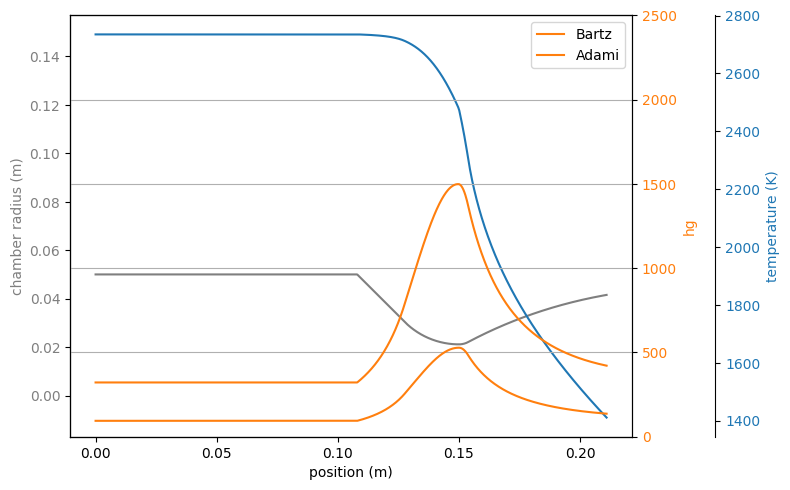

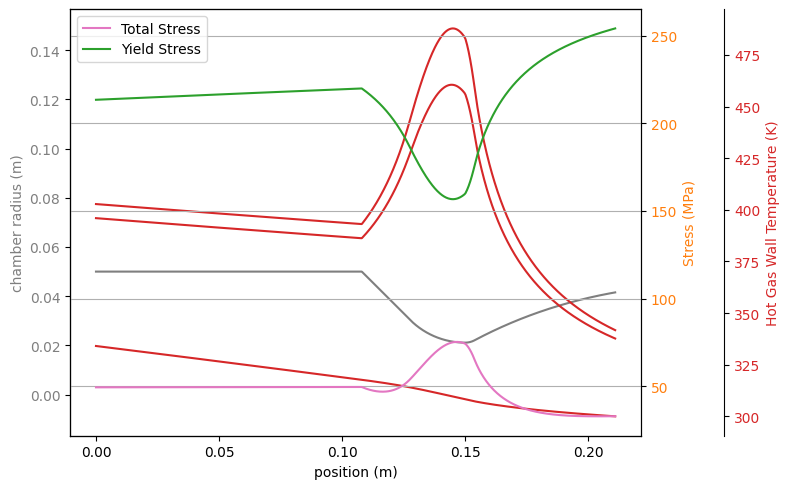

In [20]:
card_str = """
fuel CH3OH(L)   C 1 H 4 O 1
h,cal=-57040.0      t(k)=298.15       wt%=90.0
oxid water H 2 O 1  wt%=10.0
h,cal=-68308.  t(k)=298.15 rho,g/cc = 0.9998
"""
add_new_fuel( 'funnymix', card_str )

thanos = RocketEngine(
    oxName = "N2O",
    fuelName = "Methanol",
    thrust = 4000,
    Pc = 20,
    Pe = 0.85,
    MR = 2.5) #thats O/F


from matplotlib import pyplot as plt
thanos_contour = Contour(thanos, 0.15, 0.05, 1000)
thanos_thermals = Thermals(thanos, thanos_contour, 0)

print(f'Mass flux (kg/s) = {thanos.mdot}')
print(f'Throat      (mm) = {thanos_contour.throat}')
print(f'Exit        (mm) = {thanos_contour.exit}')
print(f'Cylinder r  (mm) = {thanos_contour.rc}')
print(f'Parabola    (mm) = {thanos_contour.parabola_p1}')
print(f'ISP         (mm) = {thanos.isp}')

fig, ax1 = plt.subplots()
fig.set_size_inches(8, 5)

color = 'tab:gray'
ax1.set_xlabel('position (m)')
ax1.set_ylabel('chamber radius (m)', color=color)
ax1.plot(thanos_contour.x, thanos_contour.r, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_aspect('equal', adjustable='box')
ax1.set_ylim(0, 0.14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('temperature (K)', color=color)  # we already handled the x-label with ax1
ax2.plot(thanos_contour.x, thanos_thermals.T, color=color)
ax2.spines['right'].set_position(('outward', 60))
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:orange'
ax3.set_ylabel('hg', color=color)  # we already handled the x-label with ax1
ax3.plot(thanos_contour.x, thanos_thermals.hg1, color=color, label='Bartz')
ax3.plot(thanos_contour.x, thanos_thermals.hg2, color=color, label='Adami')
ax3.tick_params(axis='y', labelcolor=color)

#ax1.set_aspect('equal', adjustable='box')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax3.set_yticks(np.arange(0, 3000, 500))
plt.grid()
plt.legend(loc='upper right')
plt.show()

thanos_channel = Channels(thanos, thanos_contour, thanos_thermals, 0.001)
channelSim = ChannelSim(thanos, thanos_contour, thanos_thermals, thanos_channel)

fig, ax1 = plt.subplots()
fig.set_size_inches(8, 5)

color = 'tab:gray'
ax1.set_xlabel('position (m)')
ax1.set_ylabel('chamber radius (m)', color=color)
ax1.plot(thanos_contour.x, thanos_contour.r, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_aspect('equal', adjustable='box')
ax1.set_ylim(0, 0.14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Hot Gas Wall Temperature (K)', color=color)  # we already handled the x-label with ax1
# # ax2.plot(thanos_contour.x, channelSim.stress_temperature, color=color, label='stress_temp')
# # ax2.plot(thanos_contour.x, channelSim.stress_temperature2, color=color, label='stress_temp')
# # ax2.plot(thanos_contour.x, channelSim.stress_pressure, color=color, label='stress_pressure')
# # ax2.plot(thanos_contour.x, channelSim.stress_pressure + channelSim.stress_temperature + channelSim.stress_temperature2, color=color, label='stress_pressure')
ax2.spines['right'].set_position(('outward', 60))
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:orange'
ax3.set_ylabel('Stress (MPa)', color=color)  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor=color)
ax2.plot(thanos_contour.x, channelSim.Twg, color='tab:red', label='T Combustion Side Wall')
ax2.plot(thanos_contour.x, channelSim.Twc, color='tab:red', label='T Coolant Side Wall')
ax2.plot(thanos_contour.x, channelSim.Tco, color='tab:red', label='T Coolant Bulk')

# ax3.plot(thanos_contour.x, channelSim.stress_temperature * 1e-6, color=color, label='Hoop stress')
# ax3.plot(thanos_contour.x, channelSim.stress_temperature2 * 1e-6, color='tab:brown', label='Tangential Thermal Stress')
# ax3.plot(thanos_contour.x, channelSim.stress_pressure * 1e-6, color='tab:blue', label='Axial Thermal Stress')
ax3.plot(thanos_contour.x, channelSim.stress_total * 1e-6, color='tab:pink', label='Total Stress')
ax3.plot(thanos_contour.x, lininterp(channelSim.Twg, 273, 573, 300e6, 100e6) * 1e-6, color='tab:green', label='Yield Stress')

#ax1.set_aspect('equal', adjustable='box')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#ax3.set_yticks(np.arange(0, 3000, 500))
plt.grid()
plt.legend(loc='upper left')
plt.show()

In [15]:
channelSim.hg.shape

(1000,)

In [16]:
max(channelSim.stress_pressure + channelSim.stress_temperature + channelSim.stress_temperature2)

75319086.3201528

In [17]:
channelSim.velocity[400]

4.259354558924553

In [18]:
thanos_thermals.[400]

SyntaxError: ignored